In [705]:
import pandas as pd
import matplotlib.pyplot as plt
import ssl
import geopandas as gpd
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import webbrowser

In [706]:
""" In de provincie Utrecht voor de 26 gemeentes, op buurt niveau een analyse van variabelen"""

' In de provincie Utrecht voor de 26 gemeentes, op buurt niveau een analyse van variabelen'

## select y variabele: welke gemeente en locaties

In [707]:
provincie_utrecht_gemeente =[
    'Amersfoort',
    'Baarn',
    'Bunnik',
    'Bunschoten',
    'De Bilt',
    'De Ronde Venen',
    'Eemnes',
    'Houten',
    'Leusden',
    'Lopik',
    'Montfoort',
    'Nieuwegein',
    'Oudewater',
    'Renswoude',
    'Rhenen',
    'Soest',
    'Stichtse Vecht',
    'Utrecht',
    'Utrechtse Heuvelrug',
    'Veenendaal',
    'Vijfheerenlanden',
    'Wijk bij Duurstede',
    'Woerden',
    'Woudenberg',
    'IJsselstein',
    'Zeist']

gemeente_selectie = provincie_utrecht_gemeente

In [708]:
# # gemeente_selectie = ['Houten', 'Utrecht', 'Zeist', 'De Bilt', 'Soest', 'Bunnik', 'Leusden', 'Amersfoort'] # nog geen nabijheidsvar voor
# gemeente_selectie = ['Houten', 'Utrecht']
# # gemeente_selectie = [ 'Utrecht']

# gemeente_selectie = ['Houten']

<AxesSubplot: >

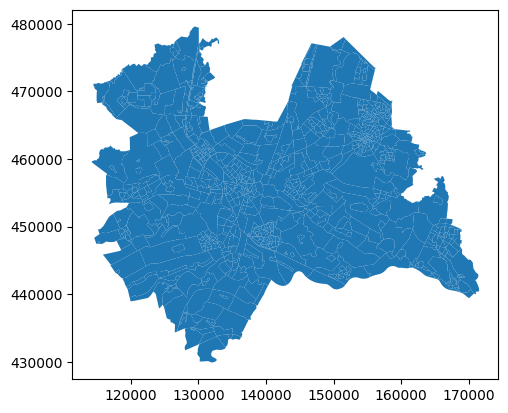

In [740]:
##### CREATE MAP #####
file_path = '../data/buurt_2020_v3.shp'
buurten_map = gpd.read_file(file_path)

gem_map = buurten_map.loc[buurten_map['GM_NAAM'].isin(gemeente_selectie)]

# drop_buurten_houten = ['Buitengebied Houten West',
#        'Buitengebied Houten Oost', "Dorp 't Goy", "'t Goyse Dorp",
#        "Buitengebied 't Goy", "'t Waal", 'Tull',
#        "Buitengebied Tull en 't Waal", 'Dorp Schalkwijk West',
#        'Dorp Schalkwijk Oost', 'Buitengebied Schalkwijk West',
#        'Buitengebied Schalkwijk Oost','Bruggen', 'Bogen', 'De Poel',
#        'Schepen', 'Boten', 'Honen', 'Kaden', 'Vesten', 'De Staart',
#        'Hof van Wulven', 'Rondweg Noord-Oost', 'Rondweg Noord-West',
#        'Rondweg Zuid-Oost', 'Rondweg Zuid-West'] 

# drop_buurten_utrecht = [
#        'Bedrijventerrein Lageweide',
#        'Haarzuilens en omgeving',
#        'Bedrijventerrein en omgeving',
#        'Utrecht Science Park',
#               'Bedrijvengebied Strijkviertel', 
#               'Bedrijvengebied Papendorp',
#               'Rijnenburg',
#               'Poldergebied Overvecht' ,
#               ]

# gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_houten)]
# gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_utrecht)]

gem_map.plot()

# plt.savefig('plots/gem_map.png')

In [742]:
gem_map.loc[gem_map['BU_NAAM'] == 'De Horden Stenen en Ovens']

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,IND_WBI,H2O,POSTCODE,DEK_PERC,OAD,...,AV20PODIUM,AF_MUSEUM,AV5_MUSEUM,AV10MUSEUM,AV20MUSEUM,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
3942,BU03520006,De Horden Stenen en Ovens,WK035200,GM0352,Wijk bij Duurstede,1,NEE,3961,1,1512,...,9.0,2.1,1.0,2.0,11.5,2020BU03520006,2020,1943.472103,214956.72881,"POLYGON ((151167.884 443456.103, 151172.192 44..."


## select x variabele: select and create features

In [710]:
def clean_up_columns(X, clean_up_columns):
    for column in clean_up_columns:
        X[column] = X[column].replace(",", ".", regex=True)  
        X[column] = X[column].replace('       .', '.', regex=True)    
        X.loc[X[column] == '.', column] = 0
        X[column] = X[column].astype(float)

In [711]:
##### CREATE BUURTEN DATASET #####
totale_dataset_kerncijfers = pd.read_excel('../data/kwb-2022.xlsx')
gemeente_kerncijfers = totale_dataset_kerncijfers.loc[totale_dataset_kerncijfers['gm_naam'].isin(gemeente_selectie)]
kerncijfers = gemeente_kerncijfers.loc[gemeente_kerncijfers['recs'] == 'Buurt']
buurt_id = kerncijfers[['gwb_code_10', 'regio']]
buurt_id.head()

,gwb_code_10,regio
4205,BU03070100,Hof
4206,BU03070101,Nieuwstraat e.o.
4207,BU03070102,Mooierstraat e.o.
4208,BU03070103,Lieve Vrouwekerkhof
4209,BU03070104,Coninckstraat e.o.


In [712]:
# select kerncijfers
kerncijfers = kerncijfers.drop(['gwb_code_8', 'regio', 'gm_naam', 'recs','gwb_code','ind_wbi'], axis=1)
relevante_kerncijfers_sel = ['gwb_code_10', 'a_inw', 'a_25_44',  'a_hh_m_k', 'g_hhgro', 'a_woning', 'g_woz', 'p_mgezw', 'p_bewndw', 'p_koopw', 'p_bjo2k']
kerncijfers_sel = kerncijfers[relevante_kerncijfers_sel]
kerncijfers_sel['a_25_44'] = ((kerncijfers_sel['a_25_44'] / kerncijfers_sel['a_inw']) * 100)
kerncijfers_sel['a_hh_m_k'] = ((kerncijfers_sel['a_hh_m_k'] / kerncijfers_sel['a_inw']) * 100)
clean_up_columns(kerncijfers_sel, ['g_hhgro', 'g_woz', 'p_mgezw', 'p_bewndw', 'p_koopw', 'p_bjo2k'])
kerncijfers_sel.head()

/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/3754452782.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kerncijfers_sel['a_25_44'] = ((kerncijfers_sel['a_25_44'] / kerncijfers_sel['a_inw']) * 100)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/3754452782.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kerncijfers_sel['a_hh_m_k'] = ((kerncijfers_sel['a_hh_m_k'] / kerncijfers_sel['a_inw']) * 100)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/626

,gwb_code_10,a_inw,a_25_44,a_hh_m_k,g_hhgro,a_woning,g_woz,p_mgezw,p_bewndw,p_koopw,p_bjo2k
4205,BU03070100,710,36.619718,5.633803,1.4,396,335.0,69.0,91.0,26.0,2.0
4206,BU03070101,460,32.608696,8.695652,1.6,259,420.0,61.0,93.0,41.0,11.0
4207,BU03070102,165,24.242424,12.121212,1.7,100,440.0,72.0,89.0,45.0,0.0
4208,BU03070103,465,32.258065,8.602151,1.6,298,341.0,77.0,94.0,33.0,1.0
4209,BU03070104,1255,33.864542,8.764940,1.6,772,308.0,48.0,95.0,29.0,5.0


In [713]:
nabijheid1 = pd.read_csv('../data/85231NED_UntypedDataSet_06012023_093617.csv' , delimiter=';')
nabijheid2 = pd.read_csv('../data/85231NED_UntypedDataSet_06012023_093718.csv' , delimiter=';')

nabijheid = pd.concat([nabijheid1, nabijheid2])
nabijheid = nabijheid.loc[nabijheid['SoortRegio_2'] == 'Buurt     ']
nabijheid = nabijheid.drop(['ID', 'WijkenEnBuurten', 'Gemeentenaam_1', 'SoortRegio_2','IndelingswijzigingWijkenEnBuurten_4'], axis=1)
nabijheid.head()

,Codering_3,AfstandTotHuisartsenpraktijk_5,Binnen1Km_6,Binnen3Km_7,Binnen5Km_8,AfstandTotHuisartsenpost_9,AfstandTotApotheek_10,AfstandTotZiekenhuis_11,Binnen5Km_12,Binnen10Km_13,...,Binnen5Km_105,Binnen10Km_106,Binnen20Km_107,AfstandTotSauna_108,AfstandTotZonnebank_109,AfstandTotAttractie_110,Binnen10Km_111,Binnen20Km_112,Binnen50Km_113,AfstandTotBrandweerkazerne_114
2,BU03070100,0.8,2.1,14.0,20.0,.,0.9,2.3,2.0,2.9,...,2.0,2.0,5.0,0.5,0.7,3.3,2.0,5.0,52.2,1.1
3,BU03070101,0.5,2.2,14.0,20.3,.,0.9,2.6,2.0,3.0,...,2.0,2.0,5.0,0.5,0.5,3.5,2.0,5.0,52.3,1.4
4,BU03070102,0.5,2.0,14.0,20.7,.,0.7,2.6,2.0,3.0,...,2.0,2.0,5.0,0.6,0.3,3.3,2.0,5.0,52.1,1.4
5,BU03070103,0.7,2.0,14.0,17.9,.,0.7,2.4,2.0,2.2,...,2.0,2.0,5.0,0.8,0.5,3.1,2.0,5.0,52.0,1.1
6,BU03070104,0.7,2.4,14.0,19.9,.,0.7,2.6,2.0,3.0,...,2.0,2.0,5.0,0.3,0.7,3.6,2.0,5.0,52.2,1.3


In [714]:
relevante_nabijheid_sel = [ 'Codering_3',
                            'AfstandTotZiekenhuis_11',
                            'AfstandTotGroteSupermarkt_24', 
                            'AfstandTotCafeED_36',
                            'AfstandTotKinderdagverblijf_52', 
                            'AfstandTotBuitenschoolseOpvang_56', 
                            'AfstandTotOpenbaarGroenTotaal_76', 
                            'AfstandTotParkOfPlantsoen_77', 
                            'AfstandTotBos_79',
                            'AfstandTotOpritHoofdverkeersweg_89',
                            'AfstandTotTreinstationsTotaal_90', 
                            'AfstandTotSemiOpenbaarGroenTotaal_83']

In [715]:
relevante_nabijheid_sel

['Codering_3',
 'AfstandTotZiekenhuis_11',
 'AfstandTotGroteSupermarkt_24',
 'AfstandTotCafeED_36',
 'AfstandTotKinderdagverblijf_52',
 'AfstandTotBuitenschoolseOpvang_56',
 'AfstandTotOpenbaarGroenTotaal_76',
 'AfstandTotParkOfPlantsoen_77',
 'AfstandTotBos_79',
 'AfstandTotOpritHoofdverkeersweg_89',
 'AfstandTotTreinstationsTotaal_90',
 'AfstandTotSemiOpenbaarGroenTotaal_83']

In [716]:
nabijheid_sel = nabijheid[relevante_nabijheid_sel]
clean_cols = [
 'AfstandTotZiekenhuis_11',
 'AfstandTotGroteSupermarkt_24',
 'AfstandTotCafeED_36',
 'AfstandTotKinderdagverblijf_52',
 'AfstandTotBuitenschoolseOpvang_56',
 'AfstandTotOpenbaarGroenTotaal_76',
 'AfstandTotParkOfPlantsoen_77',
 'AfstandTotBos_79',
 'AfstandTotOpritHoofdverkeersweg_89',
 'AfstandTotTreinstationsTotaal_90',
 'AfstandTotSemiOpenbaarGroenTotaal_83']
clean_up_columns(nabijheid_sel, clean_cols)


/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/62638556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].replace(",", ".", regex=True)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/62638556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].replace('       .', '.', regex=True)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_61212/62638556.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [717]:
leefbarometer = pd.read_csv('../data/Leefbaarometer 3.0 - meting 2020 - scores buurt.csv')  
leefbarometer = leefbarometer.loc[leefbarometer['jaar'] == 2020]
leefbarometer = leefbarometer.drop(['versie', 'jaar', 'bu_naam', 'afw', 'won'], axis=1)
leefbarometer.head()

,bu_code,lbm,fys,onv,soc,vrz
6,BU00030000,4.118757,0.018589,0.018267,0.016757,-0.066506
13,BU00030001,4.104090,0.008886,0.040026,0.036772,-0.117861
20,BU00030002,4.011682,0.023694,-0.006718,-0.000822,-0.105294
27,BU00030007,4.228319,-0.004327,0.097363,0.112268,-0.156507
34,BU00030008,4.197940,-0.076229,0.098263,0.126321,-0.200758


In [718]:
energieverbruik = pd.read_csv('../data/Energieverbruik_woningen__wijkbuurt_2021_06012023_100550.csv', delimiter=';') ## per buurt in utrecht selectie opendata
energieverbruik = buurt_id.merge(energieverbruik, left_on='regio', right_on='Wijken en buurten', how ='left')
energieverbruik = energieverbruik.loc[energieverbruik['gwb_code_10'].notna()]
energieverbruik = energieverbruik.loc[energieverbruik['Gemiddeld aardgasverbruik (m3)'].notna()]
energieverbruik = energieverbruik.drop(['Woningkenmerken', 'Wijken en buurten', 'regio', 'Indelingswijziging wijken en buurten (code)', 'Stadsverwarming (%)'], axis=1)
clean_up_columns(energieverbruik, ['Gemiddeld aardgasverbruik (m3)', 'Gemiddeld elektriciteitsverbruik (kWh)'])
energieverbruik = energieverbruik.groupby("gwb_code_10").agg({
    'Gemiddeld aardgasverbruik (m3)' : 'mean', 
    'Gemiddeld elektriciteitsverbruik (kWh)' : 'mean'}).reset_index()

energieverbruik.head()

,gwb_code_10,Gemiddeld aardgasverbruik (m3),Gemiddeld elektriciteitsverbruik (kWh)
0,BU03070100,1310.0,2430.0
1,BU03070101,1280.0,2600.0
2,BU03070102,1350.0,2770.0
3,BU03070103,1170.0,2290.0
4,BU03070104,1150.0,2300.0


In [719]:
social_economische_score = pd.read_csv('../data/SES_WOA_scores_per_wijk_en_buurt_06012023_102134.csv', delimiter=';') ## per buurt (ook gemeente en wijk regels) in utrecht selectie opendata
social_economische_score = social_economische_score.merge(buurt_id, left_on='Wijken en buurten', right_on='regio', how ='left')
social_economische_score = social_economische_score.drop(['Perioden', 'Wijken en buurten', 'regio', 'Spreiding/Spreiding totaal/Waarde (Getal)','Particuliere huishoudens (Aantal)' ], axis=1)
social_economische_score = social_economische_score.loc[social_economische_score['gwb_code_10'].notna()]
social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'] = social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'].replace('       .', '.', regex=True) 
social_economische_score.loc[social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'] == '.', 'SES-WOA/Totaalscore/Gemiddelde score (Getal)'] = 0
social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'] = social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'].astype(float)
social_economische_score = social_economische_score.loc[social_economische_score['SES-WOA/Totaalscore/Gemiddelde score (Getal)'].notna()]
social_economische_score = social_economische_score.groupby("gwb_code_10").agg({
    'SES-WOA/Totaalscore/Gemiddelde score (Getal)' : 'mean'}).reset_index()
social_economische_score.head()

,gwb_code_10,SES-WOA/Totaalscore/Gemiddelde score (Getal)
0,BU03070100,-0.116
1,BU03070101,0.088
2,BU03070102,0.000
3,BU03070103,-0.041
4,BU03070104,-0.125


In [720]:
geluid_per_buurt = pd.read_csv('../data/50066NED_UntypedDataSet_06012023_103445.csv', delimiter=';') ## https://statline.rivm.nl/portal.html?_la=nl&_catalog=RIVM&tableId=50066NED&_theme=96
geluid_per_buurt = geluid_per_buurt.loc[geluid_per_buurt['SoortRegio_2'] == 'Buurt   ']
unieke_buurt_ids = buurt_id['gwb_code_10'].unique().tolist()
geluid_per_buurt = geluid_per_buurt.loc[geluid_per_buurt['Codering_3'].isin(unieke_buurt_ids)]
geluid_per_buurt = geluid_per_buurt.drop(['ID', 'Geluidblootstelling', 'WijkenEnBuurten', 'Gemeentenaam_1','SoortRegio_2','Bevolking_6' ], axis=1)
clean_up_columns(geluid_per_buurt, ['GeluidVanTreinverkeer_4', 'GeluidVanWegverkeer_5'])

geluid_per_buurt = geluid_per_buurt.groupby("Codering_3").agg({
    'GeluidVanTreinverkeer_4' : 'mean',
    'GeluidVanWegverkeer_5': 'mean'}).reset_index()
social_economische_score.head()
geluid_per_buurt.head()

,Codering_3,GeluidVanTreinverkeer_4,GeluidVanWegverkeer_5
0,BU03070100,20.00,31.65
1,BU03070101,20.00,27.01
2,BU03070102,20.00,24.79
3,BU03070103,20.00,30.61
4,BU03070104,20.45,28.56


In [721]:
#groen_per_buurt = nog niet een goede dataset gevonden

In [722]:
# datasets = [kerncijfers, nabijheid, leefbarometer, energieverbruik, social_economische_score, geluid_per_buurt]

In [723]:
# len(kerncijfers), len(nabijheid)

In [724]:
# MERGING DATASETS PER BUURT

buurten = pd.DataFrame(buurt_id['gwb_code_10'])
buurten = buurten.merge(kerncijfers_sel, left_on='gwb_code_10',right_on='gwb_code_10', how='left')
buurten = buurten.merge(nabijheid_sel, left_on='gwb_code_10',right_on='Codering_3', how='left')
buurten = buurten.merge(leefbarometer, left_on='gwb_code_10',right_on='bu_code', how='left')
buurten = buurten.merge(energieverbruik, left_on='gwb_code_10',right_on='gwb_code_10', how='left')
buurten = buurten.merge(social_economische_score, left_on='gwb_code_10',right_on='gwb_code_10', how='left')
buurten = buurten.merge(geluid_per_buurt, left_on='gwb_code_10',right_on='Codering_3', how='left')
buurten = buurten.drop(['Codering_3_x', 'bu_code','Codering_3_y'], axis=1)
buurten.head()

,gwb_code_10,a_inw,a_25_44,a_hh_m_k,g_hhgro,a_woning,g_woz,p_mgezw,p_bewndw,p_koopw,...,lbm,fys,onv,soc,vrz,Gemiddeld aardgasverbruik (m3),Gemiddeld elektriciteitsverbruik (kWh),SES-WOA/Totaalscore/Gemiddelde score (Getal),GeluidVanTreinverkeer_4,GeluidVanWegverkeer_5
0,BU03070100,710,36.619718,5.633803,1.4,396,335.0,69.0,91.0,26.0,...,4.223513,0.016603,-0.137433,-0.036480,0.238134,1310.0,2430.0,-0.116,20.00,31.65
1,BU03070101,460,32.608696,8.695652,1.6,259,420.0,61.0,93.0,41.0,...,4.258153,0.016577,-0.103174,-0.033208,0.239964,1280.0,2600.0,0.088,20.00,27.01
2,BU03070102,165,24.242424,12.121212,1.7,100,440.0,72.0,89.0,45.0,...,4.279050,0.037387,-0.108321,-0.031483,0.242077,1350.0,2770.0,0.000,20.00,24.79
3,BU03070103,465,32.258065,8.602151,1.6,298,341.0,77.0,94.0,33.0,...,4.182794,0.018444,-0.175005,-0.045186,0.257935,1170.0,2290.0,-0.041,20.00,30.61
4,BU03070104,1255,33.864542,8.764940,1.6,772,308.0,48.0,95.0,29.0,...,4.218727,0.008662,-0.092441,-0.043167,0.218342,1150.0,2300.0,-0.125,20.45,28.56


In [725]:
### RENAME COLUMNS TO READABLE FORMAT
rename_columns_dict = {
 'gwb_code_10': 'buurt_code',
 'a_inw': 'aantal_inwoners',
 'a_25_44': 'aantal_inwoners_tussen_25_44_percentage',
 'a_hh_m_k': 'aantal_huishoudens_met_kinderen_percentage',
 'g_hhgro': 'gemiddelde_huishoudensgrootte',
 'a_woning': 'woningvoorraad',
 'g_woz': 'gemiddelde_woningwaarde',
 'p_mgezw':'meergezinswoning_percentage',
 'p_bewndw':'bewoond_percentage',
 'p_koopw': 'koopwoning_percentage',
 'p_bjo2k': 'bouwjaar_vanaf_2000_percentage',
 'AfstandTotZiekenhuis_11': 'afstand_tot_ziekenhuis_km',
 'AfstandTotGroteSupermarkt_24': 'afstand_tot_grote_supermarkt_km',
 'AfstandTotCafeED_36': 'afstand_tot_cafe_km',
 'AfstandTotKinderdagverblijf_52': 'afstand_tot_kinderdagverblijf_km',
 'AfstandTotBuitenschoolseOpvang_56': 'afstand_tot_buitenschoolseopvang_km',
 'AfstandTotOpenbaarGroenTotaal_76': 'afstand_tot_openbaar_groen_km',
 'AfstandTotParkOfPlantsoen_77': 'afstand_tot_park_of_plantsoen_km',
 'AfstandTotBos_79': 'afstand_tot_bos_km',
 'AfstandTotOpritHoofdverkeersweg_89': 'afstand_tot_hoofdverkeersweg_km',
 'AfstandTotTreinstationsTotaal_90': 'afstand_tot_treinstation_km',
 'lbm': 'leefbarometer_score',
 'fys': 'leefbarometer_fysieke_omgeving',
 'onv': 'leefbarometer_fysieke_overlast',
 'soc': 'leefbarometer_sociale_samenhang',
 'vrz': 'leefbarometer_voorzieningen',
 'Gemiddeld aardgasverbruik (m3)': 'aardgasverbruik_m3_gemiddeld',
 'Gemiddeld elektriciteitsverbruik (kWh)': 'elektriciteitsverbruik_kwh_gemiddeld',
 'SES-WOA/Totaalscore/Gemiddelde score (Getal)':'social_economische_score_gemiddeld',
 'GeluidVanTreinverkeer_4': 'geluid_van_treinverkeer',
 'GeluidVanWegverkeer_5': 'geluid_van_weg'}

In [726]:
#### EDIT COLUMN
buurten.rename(columns=rename_columns_dict,
          inplace=True)
 

In [727]:
# buurten.info()

In [728]:
### CHECK FOR WHICH BUURTEN WE DO NOT HAVE ENOUGH DATA
buurten = buurten.dropna()  #for now we just drop them

#create x and y var
y = pd.DataFrame(buurten['buurt_code'])
X = buurten[buurten.columns[~buurten.columns.isin(y.columns)]]


In [729]:
# ### CREATE INPUT DATASET
# gebruikte_variabelen = {
#     'buurt_code': 'gwb_code_10',
#     'regio':'regio',
#     'aantal inwoners': 'a_inw',
#     'inwoners tussen 25 en 44':'a_25_44',
#     'westerse inwoners': 'a_w_all',
#     'huishoudens met kinderen': 'a_hh_m_k',
#     'gemiddele huishoudgrootte': 'g_hhgro', 
#     'woningvoorraad': 'a_woning',
#     'gemiddelde woz waarde':'g_woz',
#     'percentage eengezinswoning': 'p_1gezw',
#     'percentage meergezinswoning': 'p_mgezw',
#     'percentage koopwoningen': 'p_koopw', 
#     'bouwjaar na 2000': 'p_bjo2k',
#     'Personen autos per huishouden': 'g_pau_hh',
#     'Omgevingsadressendichtheid ':'ste_oad',
#     'afstand tot huisarts': 'Gezondheid en welzijn/Huisartsenpraktijk/Afstand tot huisartsenpost (km)',
#     'afstand tot apotheek': 'Gezondheid en welzijn/Afstand tot apotheek (km)', 
#     'afstand tot supermarkt':  'Detailhandel/Winkels dagelijkse boodschappen/Afstand tot grote supermarkt (km)',
#     'afstand tot warenhuis':  'Detailhandel/Warenhuis/Afstand tot warenhuis (km)',
#     'afstand tot cafe':  'Horeca/Cafés en dergelijke/Afstand tot café e.d. (km)',
#     'afstand tot oprit hoofdverkeersweg' : 'Verkeer en vervoer/Afstand tot oprit hoofdverkeersweg (km)',
#     'afstand tot trein':  'Verkeer en vervoer/Treinstations/Afstand tot treinstations totaal (km)',
#     }    

# lijst_gebruik = []
# [lijst_gebruik.append(values) for key, values in gebruikte_variabelen.items()]
# analyse_dataset = buurten[lijst_gebruik]

# y_columns = ['gwb_code_10', 'regio']
# Y = analyse_dataset[['gwb_code_10', 'regio']]
# X = analyse_dataset[analyse_dataset.columns[~analyse_dataset.columns.isin(y_columns)]]

In [730]:
jasmee_buurt = 'Oud Hoograven-Zuid'
haja_buurt = 'Slagen'
nelize_buurt = 'Voordorp en Voorveldsepolder'

In [731]:
# ##### FEATURE PREP ######
# clean_up_columns = ['g_hhgro', 'g_woz', 'p_1gezw', 'p_mgezw',
# 'p_koopw', 'p_bjo2k', 'g_pau_hh','ste_oad',
# 'Gezondheid en welzijn/Huisartsenpraktijk/Afstand tot huisartsenpost (km)',
# 'Gezondheid en welzijn/Afstand tot apotheek (km)',
# 'Detailhandel/Winkels dagelijkse boodschappen/Afstand tot grote supermarkt (km)',
# 'Detailhandel/Warenhuis/Afstand tot warenhuis (km)',
# 'Horeca/Cafés en dergelijke/Afstand tot café e.d. (km)',
# 'Verkeer en vervoer/Afstand tot oprit hoofdverkeersweg (km)',
# 'Verkeer en vervoer/Treinstations/Afstand tot treinstations totaal (km)'
# ]

# for column in clean_up_columns:
#     X[column] = X[column].replace(",", ".", regex=True)  
#     X[column] = X[column].replace('       .', '.', regex=True)    
#     X.loc[X[column] == '.', column] = 0
#     X[column] = X[column].astype(float).astype(int)


## run model en predictor

In [732]:
cosine_sim_matrix = cosine_similarity(X, X)

In [733]:
##### SIMILARITY ######

# Function that gets movie recommendations based on the cosine similarity score of movie genres
def buurten_recommendations(regio, map_df, n_predictions, analyse_dataset, cosine_sim_matrix, buurt_id_naam_mapper, features_visualisatie):
    code = buurt_id_naam_mapper.loc[buurt_id_naam_mapper['regio'] == regio, 'gwb_code_10'].item()
    buurten = analyse_dataset['buurt_code']
    indices = pd.Series(analyse_dataset.index, index=analyse_dataset['buurt_code']) 

    # create dataframe with predictions
    idx = indices[code]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_predictions+1]
    scores = [i[1] for i in sim_scores]
    scores = [round(score,4) for score in scores]
    buurten_indices = [i[0] for i in sim_scores]
    recommendations = buurten.iloc[buurten_indices]
    recommendations_df = pd.DataFrame(list(zip(recommendations, scores)))
    recommender_id = np.append(recommendations_df[0].unique(), code)
    recommender_naam = buurt_id_naam_mapper.loc[buurt_id_naam_mapper['gwb_code_10'].isin(recommender_id), 'regio'].to_list()
    
    # create plot with predictions
    merged_df = map_df.merge(recommendations_df, left_on='BU_CODE', right_on=0, how='left')
    merged_df.loc[~merged_df[1].isnull(),'dummy'] = 1
    merged_df.loc[merged_df[1].isnull(),'dummy'] = 0.5
    merged_df.loc[merged_df['BU_NAAM'] == regio, 'dummy'] = 0

    # Maak een thematische kaart
    p = merged_df.plot(column="dummy",
                        figsize = (6,4),
                        cmap='RdYlGn')
    p.axis('off')
    p.set_title(f'Voor jouw buurt "{regio}", woorden de volgende buurten geadvisereed:')

    geometry = map_df[['geometry', 'BU_CODE']]
    geometry = geometry.merge(buurt_id_naam_mapper, left_on='BU_CODE', right_on='gwb_code_10')
    explore = geometry.merge(analyse_dataset, left_on='BU_CODE', right_on='buurt_code', how='left')
    explore = explore.loc[explore['BU_CODE'].isin(recommender_id)]
    explore = explore.loc[explore['BU_CODE'].isin(recommender_id)]
    explore = explore[explore.columns[explore.columns.isin(features_visualisatie)]]
    return recommender_naam, explore

In [734]:
### RENAME COLUMNS TO READABLE FORMAT
features_visualisatie = [ 'geometry', 'regio',
'buurt_code', 'aantal_inwoners', 'aantal_inwoners_tussen_25_44_percentage', 'gemiddelde_huishoudensgrootte',
 'woningvoorraad', 'gemiddelde_woningwaarde', 'meergezinswoning_percentage', 'bewoond_percentage',
 'koopwoning_percentage', 'bouwjaar_vanaf_2000_percentage', 'afstand_tot_grote_supermarkt_km', 'afstand_tot_park_of_plantsoen_km', 'afstand_tot_hoofdverkeersweg_km',
'afstand_tot_treinstation_km','leefbarometer_score', 'aardgasverbruik_m3_gemiddeld', 'elektriciteitsverbruik_kwh_gemiddeld',
 'social_economische_score_gemiddeld', 'geluid_van_treinverkeer','geluid_van_weg']

We raden de volgende buurten aan: 
Hoekveen e.o.
Eilandengroepenbuurt
Het Bosje
Voordorp en Voorveldsepolder
Groenlust


[None, None, None, None, None]

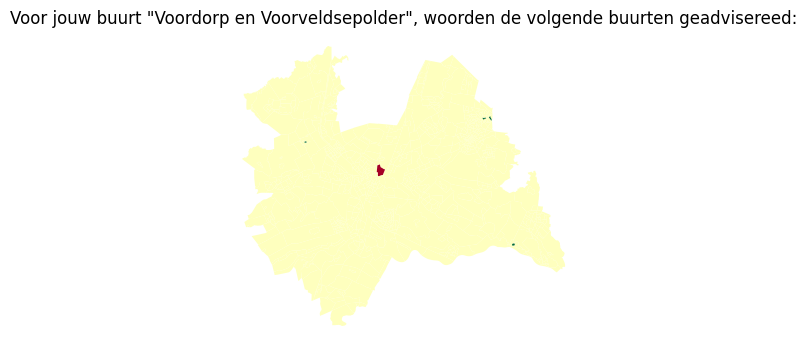

In [745]:
lijst, explore = buurten_recommendations(nelize_buurt, gem_map, 4, buurten, cosine_sim_matrix, buurt_id, features_visualisatie)
print('We raden de volgende buurten aan: ')
[print(i) for i in lijst]

In [746]:
explore_interaction = explore.explore(popup=True)

# and then we write the map to disk
explore_interaction.save('recommendations_map.html')

# then open it
webbrowser.open('file://' + os.path.realpath('recommendations_map.html'))

True

In [737]:
### TO DO:
# EDIT SO THAT OWN RECOMMENDATION IS NOT SHOWN (OWN BUURT)
# MAKE EASY SELECTION FOR WHICH GEMEENTES YOU WANT TO INCLUDE
# UITZOEKEN HOE COSINE SIMILAIRY PRECIES WERKT EN WELKE VARIABELEN IK WIL TOEVOEGEN VOOR ANALYSE VS VOOR VISUALISATIE